In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm

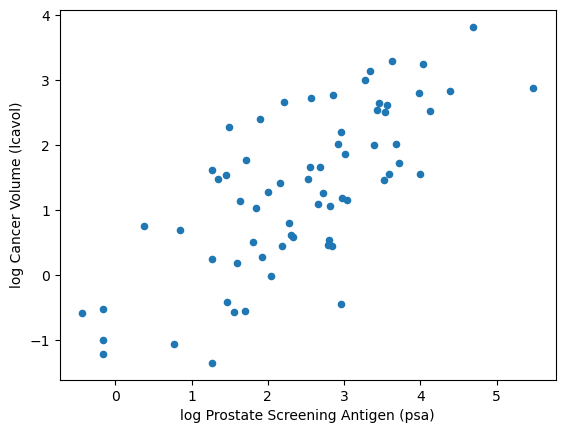

In [6]:
# Load prostate data
prostate = pd.read_csv("prostate.csv")

# Subset to training examples
prostate_train = prostate[prostate['train'] == True]

# Function to plot lcavol vs lpsa
def plot_psa_data(dat):
    plt.scatter(dat['lpsa'], dat['lcavol'], s=20)
    plt.xlabel("log Prostate Screening Antigen (psa)")
    plt.ylabel("log Cancer Volume (lcavol)")

plot_psa_data(prostate_train)
plt.show()

In [7]:
# L2 loss function
def L2_loss(y, yhat):
    return (y - yhat) ** 2

# Function to fit linear model using numerical optimization
def fit_lin(y, x, loss=L2_loss, beta_init=[-0.51, 0.75]):
    def err(beta):
        return np.mean(loss(y, beta[0] + beta[1] * x))
    result = minimize(err, beta_init)
    return result.x

# Function to make predictions from linear model
def predict_lin(x, beta):
    return beta[0] + beta[1] * x

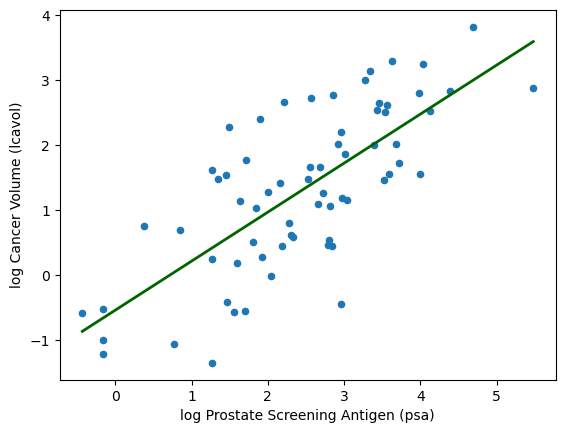

In [8]:
# Fit linear model
lin_beta = fit_lin(prostate_train['lcavol'], prostate_train['lpsa'])

# Compute predictions for a grid of inputs
x_grid = np.linspace(prostate_train['lpsa'].min(), prostate_train['lpsa'].max(), 100)
lin_pred = predict_lin(x_grid, lin_beta)

# Plot data and predictions
plot_psa_data(prostate_train)
plt.plot(x_grid, lin_pred, color='darkgreen', lw=2)
plt.show()

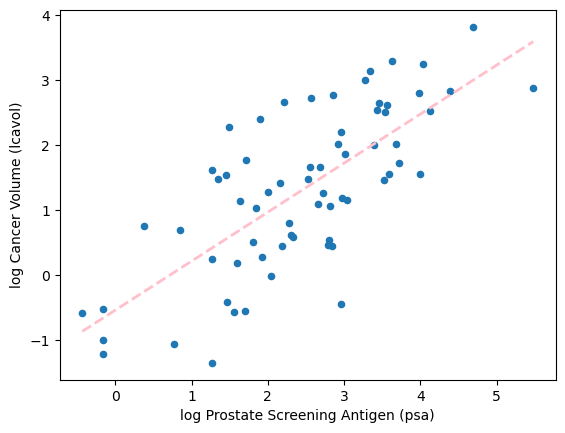

In [9]:
# Fit linear model using statsmodels (equivalent to R's lm)
lin_fit_lm = sm.OLS(prostate_train['lcavol'], sm.add_constant(prostate_train['lpsa'])).fit()
lin_pred_lm = lin_fit_lm.predict(sm.add_constant(x_grid))

# Plot predictions from lm
plot_psa_data(prostate_train)
plt.plot(x_grid, lin_pred_lm, color='pink', linestyle='--', lw=2)
plt.show()

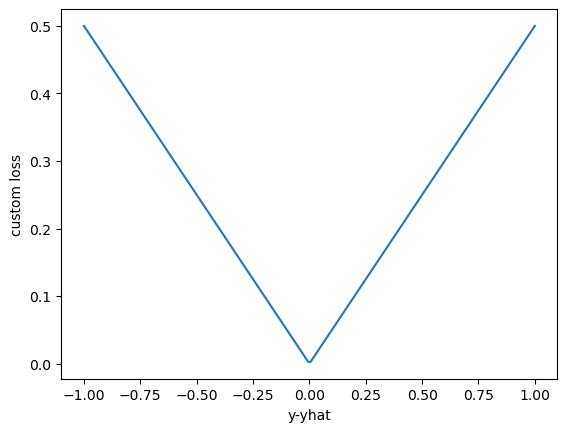

In [10]:
# Tilted absolute loss
def tilted_abs_loss(y, yhat, tau):
    d = y - yhat
    return np.where(d > 0, d * tau, d * (tau - 1))

# Plot custom loss function
err_grid = np.linspace(-1, 1, 200)
plt.plot(err_grid, tilted_abs_loss(0, err_grid, tau=0.50))
plt.xlabel('y-yhat')
plt.ylabel('custom loss')
plt.show()

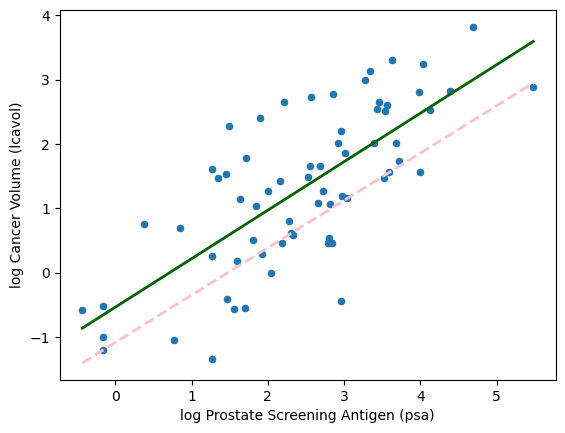

In [11]:
# Fit linear model with custom loss
lin_beta_custom = fit_lin(prostate_train['lcavol'], prostate_train['lpsa'],
                          loss=lambda y, yhat: tilted_abs_loss(y, yhat, tau=0.25))

lin_pred_custom = predict_lin(x_grid, lin_beta_custom)

# Plot data and predictions
plot_psa_data(prostate_train)
plt.plot(x_grid, lin_pred, color='darkgreen', lw=2)
plt.plot(x_grid, lin_pred_custom, color='pink', linestyle='--', lw=2)
plt.show()



In [12]:
# L1 loss function
def L1_loss(y, yhat):
    return np.abs(y - yhat)

# Tilted absolute loss function
def tilted_abs_loss(y, yhat, tau):
    d = y - yhat
    return np.where(d > 0, d * tau, d * (tau - 1))

In [13]:
# Function to fit nonlinear model using numerical optimization
def fit_nonlinear(y, x, loss=L2_loss, beta_init=[-1.0, 0.0, -0.3]):
    def err(beta):
        return np.mean(loss(y, beta[0] + beta[1] * np.exp(-beta[2] * x)))
    result = minimize(err, beta_init)
    return result.x

# Function to make predictions from nonlinear model
def predict_nonlinear(x, beta):
    return beta[0] + beta[1] * np.exp(-beta[2] * x)


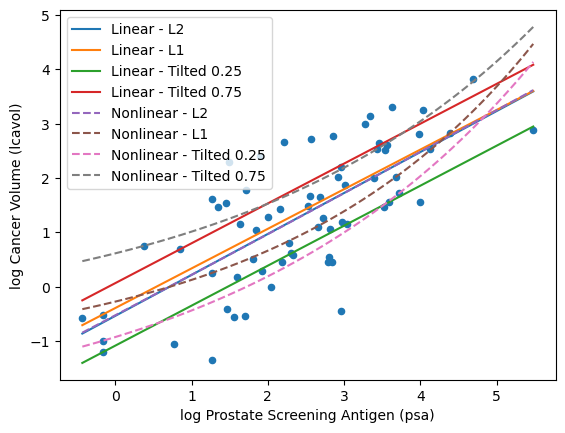

In [14]:
# Plotting linear and nonlinear model predictions
def plot_models(x, y, linear_betas, nonlinear_betas, loss_names):
    plot_psa_data(prostate_train)
    for beta, name in zip(linear_betas, loss_names):
        lin_pred = predict_lin(x, beta)
        plt.plot(x, lin_pred, label=f'Linear - {name}')
    for beta, name in zip(nonlinear_betas, loss_names):
        nonlin_pred = predict_nonlinear(x, beta)
        plt.plot(x, nonlin_pred, label=f'Nonlinear - {name}', linestyle='--')
    plt.legend()
    plt.show()

# Fit linear and nonlinear models for different losses
loss_functions = [L2_loss, L1_loss, lambda y, yhat: tilted_abs_loss(y, yhat, 0.25), 
                  lambda y, yhat: tilted_abs_loss(y, yhat, 0.75)]
loss_names = ['L2', 'L1', 'Tilted 0.25', 'Tilted 0.75']
linear_betas = [fit_lin(prostate_train['lcavol'], prostate_train['lpsa'], loss=loss) for loss in loss_functions]
nonlinear_betas = [fit_nonlinear(prostate_train['lcavol'], prostate_train['lpsa'], loss=loss) for loss in loss_functions]

# Plot linear and nonlinear model predictions
plot_models(x_grid, prostate_train['lcavol'], linear_betas, nonlinear_betas, loss_names)
